## 차례

1. 필요한 모듈 및 데이터 가져오기 + 데이터 나눠서 읽기
2. 데이터 전처리
3. 초기 상태에서 모델 학습
4. OverSampling 후 모델 학습
5. UnderSampling 후 모델 학습
6. 결과 및 결론


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. 필요한 모듈 및 데이터 가져오기 + 데이터 나눠서 읽기**

In [3]:
import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

read_csv로 한꺼번에 얻으려고 시도했지만 데이터가 지나치게 많아서 구글코랩이 버티지 못했습니다. 따라서 데이터를 분할해서 read_csv 작업을 거쳤습니다. 조건은 다음과 같습니다.

1. 날짜가 2015년에서 2016년까지인 데이터만 가져오기

2. application_type == Individual인 데이터만 가져오기

3. loan_status에서 조건에 맞게 0과 1 매길 수 있는 데이터만 가져오기

추가로 분할해서 데이터 얻을 때 마지막 행이 항상 Total amount funded in policy code 2: 521953170 이라는 행으로 변환되는 이상현상이 있어서 이에 대해서도 대체했습니다.

In [ ]:
# 데이터를 분리해서 얻고 전처리 하기 (오래 걸림!!!!!!!!!!!)
# 2260701 = (3**2) * 239 * 1051
how_many = 9
quotient = int(2260701/how_many)
for idx in range(how_many):
  if idx == 0:
    skip_list = list(range(quotient*(idx+1)+1,2260701))
    temp_df = pd.read_csv('/content/drive/MyDrive/accepted_2007_to_2018Q4.csv',skiprows=skip_list)
    col_list = temp_df.columns.tolist()
    temp_df = temp_df.iloc[:-1]
  elif idx == (how_many-1):
    skip_list = list(range(0,quotient*idx))
    temp_df = pd.read_csv('/content/drive/MyDrive/accepted_2007_to_2018Q4.csv',skiprows=skip_list)
    temp_df.columns = col_list # skiprows 사용시 colname이 바로 전행렬의 데이터로 채우지는 현상 방지
  else:
    skip_list = list(range(0,quotient*idx)) + list(range(quotient*(idx+1)+1,2260701))
    temp_df = pd.read_csv('/content/drive/MyDrive/accepted_2007_to_2018Q4.csv',skiprows=skip_list)
    temp_df.columns = col_list # skiprows 사용시 colname이 바로 전행렬의 데이터로 채우지는 현상 방지
    temp_df = temp_df.iloc[:-1]

  # 2015년 ~ 2016년 내 데이터만 생산
  new_temp_df = pd.DataFrame(temp_df['issue_d'].str.split('-',expand=True))
  new_temp_df.columns = ['mon','year']
  new_temp_df = new_temp_df.fillna(0) # 날짜가 nan이면 0으로 지정해서 자연스럽게 제거되게 만듬
  new_temp_df = new_temp_df.astype({'year':'int32'})
  date_cond = (new_temp_df[['year']] == 2015) | (new_temp_df[['year']] == 2016)
  extra_temp_df = temp_df.loc[date_cond['year']]

  # application_type == Individual
  application_type_cond = extra_temp_df[['application_type']] == 'Individual'
  extra_temp_df = extra_temp_df.loc[application_type_cond['application_type']]

  # loan_status에 따른 0과 1 매기기
  loan_status_cond = (extra_temp_df[['loan_status']] == 'Current') | (extra_temp_df[['loan_status']] == 'Fully Paid') | (extra_temp_df[['loan_status']] == 'Charged Off') | (extra_temp_df[['loan_status']] == 'Default') | (extra_temp_df[['loan_status']] == 'Late (16-30 days)') | (extra_temp_df[['loan_status']] == 'Late (31-120 days)')
  extra_temp_df = extra_temp_df.loc[loan_status_cond['loan_status']]
  extra_temp_df[['loan_status']] = extra_temp_df[['loan_status']].replace(['Current', 'Fully Paid'], 0)
  extra_temp_df[['loan_status']] = extra_temp_df[['loan_status']].replace(['Charged Off', 'Default', 'Late (16-30 days)', 'Late (31-120 days)'], 1)

  if idx == 0:
    df = extra_temp_df

  else:
    df = pd.concat([df, extra_temp_df], axis = 0)
    df = df.reset_index(drop=True)

<ipython-input-3-36caab03f773>:8: DtypeWarning: Columns (0,19,59) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv('/content/drive/MyDrive/accepted_2007_to_2018Q4.csv',skiprows=skip_list)
<ipython-input-3-36caab03f773>:17: DtypeWarning: Columns (0,19,59,118) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv('/content/drive/MyDrive/accepted_2007_to_2018Q4.csv',skiprows=skip_list)
<ipython-input-3-36caab03f773>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_temp_df[['loan_status']] = extra_temp_df[['loan_status']].replace(['Current', 'Fully Paid'], 0)
<ipython-input-3-36caab03f773>:17: DtypeWarning: Columns (0,19,118,145,146,147) have mixed typ

In [ ]:
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68426831,NaN,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843861,89885898,NaN,24000.0,24000.0,24000.0,60 months,12.79,543.50,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
843862,88977788,NaN,24000.0,24000.0,24000.0,60 months,10.49,515.74,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
843863,88985880,NaN,40000.0,40000.0,40000.0,60 months,10.49,859.56,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
843864,88224441,NaN,24000.0,24000.0,24000.0,60 months,14.49,564.56,C,C4,...,NaN,NaN,Cash,Y,Mar-2019,ACTIVE,Mar-2019,10000.0,44.82,1.0


In [ ]:
# 2015년, 2016년 데이터 다시 저장
df.to_csv('/content/drive/MyDrive/accepted_1516.csv', index=False)

In [ ]:
# 저장된 2015년, 2016년 데이터 다시 불러오기
df_1516 = pd.read_csv('/content/drive/MyDrive/accepted_1516.csv')

<ipython-input-3-e16e192e2879>:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1516 = pd.read_csv('/content/drive/MyDrive/accepted_1516.csv')


In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.0 MB/s 

In [ ]:
from pycaret import classification

# **2. 데이터 전처리**

종속변수를 제외한 모형 제외항목에 속한 변수 제거했습니다.

In [ ]:
drop_list = ['member_id','int_rate','grade','sub_grade','pymnt_plan','fico_range_low','fico_range_high',
             'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
             'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',
             'next_pymnt_d','last_credit_pull_d','last_fico_range_high','last_fico_range_low',
             'collections_12_mths_ex_med','mths_since_last_major_derog','application_type','annual_inc_joint',
             'dti_joint','verification_status_joint','tot_coll_amt','tot_cur_bal','delinq_amnt',
             'revol_bal_joint','sec_app_fico_range_low','sec_app_fico_range_high','sec_app_earliest_cr_line',
             'sec_app_inq_last_6mths','sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util',
             'sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths',
             'sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog','hardship_flag',
             'hardship_type','hardship_reason','hardship_status','deferral_term','hardship_amount',
             'hardship_start_date','hardship_end_date','payment_plan_start_date','hardship_length',
             'hardship_dpd','hardship_loan_status','orig_projected_additional_accrued_interest',
             'hardship_payoff_balance_amount','hardship_last_payment_amount','debt_settlement_flag',
             'debt_settlement_flag_date','settlement_status','settlement_date','settlement_amount',
             'settlement_percentage','settlement_term']

df_1516 = df_1516.drop(drop_list, axis=1)
df_1516

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_title,emp_length,home_ownership,annual_inc,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method
0,68407277,3600.0,3600.0,3600.0,36 months,123.03,leadman,10+ years,MORTGAGE,55000.0,...,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,Cash
1,68355089,24700.0,24700.0,24700.0,36 months,820.28,Engineer,10+ years,MORTGAGE,65000.0,...,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,Cash
2,66310712,35000.0,35000.0,35000.0,60 months,829.90,Information Systems Officer,10+ years,MORTGAGE,110000.0,...,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,Cash
3,68476807,10400.0,10400.0,10400.0,60 months,289.91,Contract Specialist,3 years,MORTGAGE,104433.0,...,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,Cash
4,68426831,11950.0,11950.0,11950.0,36 months,405.18,Veterinary Tecnician,4 years,RENT,34000.0,...,0.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,Cash
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843861,89885898,24000.0,24000.0,24000.0,60 months,543.50,Unit Operator,7 years,MORTGAGE,95000.0,...,3.0,100.0,NaN,0.0,0.0,102517.0,104422.0,0.0,52017.0,Cash
843862,88977788,24000.0,24000.0,24000.0,60 months,515.74,Database Administrator,10+ years,MORTGAGE,108000.0,...,0.0,75.9,42.9,0.0,1.0,227883.0,140118.0,27900.0,172283.0,Cash
843863,88985880,40000.0,40000.0,40000.0,60 months,859.56,Vice President,9 years,MORTGAGE,227000.0,...,0.0,75.7,50.0,0.0,0.0,55970.0,28398.0,12300.0,42670.0,Cash
843864,88224441,24000.0,24000.0,24000.0,60 months,564.56,Program Manager,6 years,RENT,110000.0,...,1.0,96.2,40.0,1.0,0.0,84664.0,62426.0,20700.0,58764.0,Cash


종속 변수 데이터 분포 확인 결과 불균형 데이터였습니다.

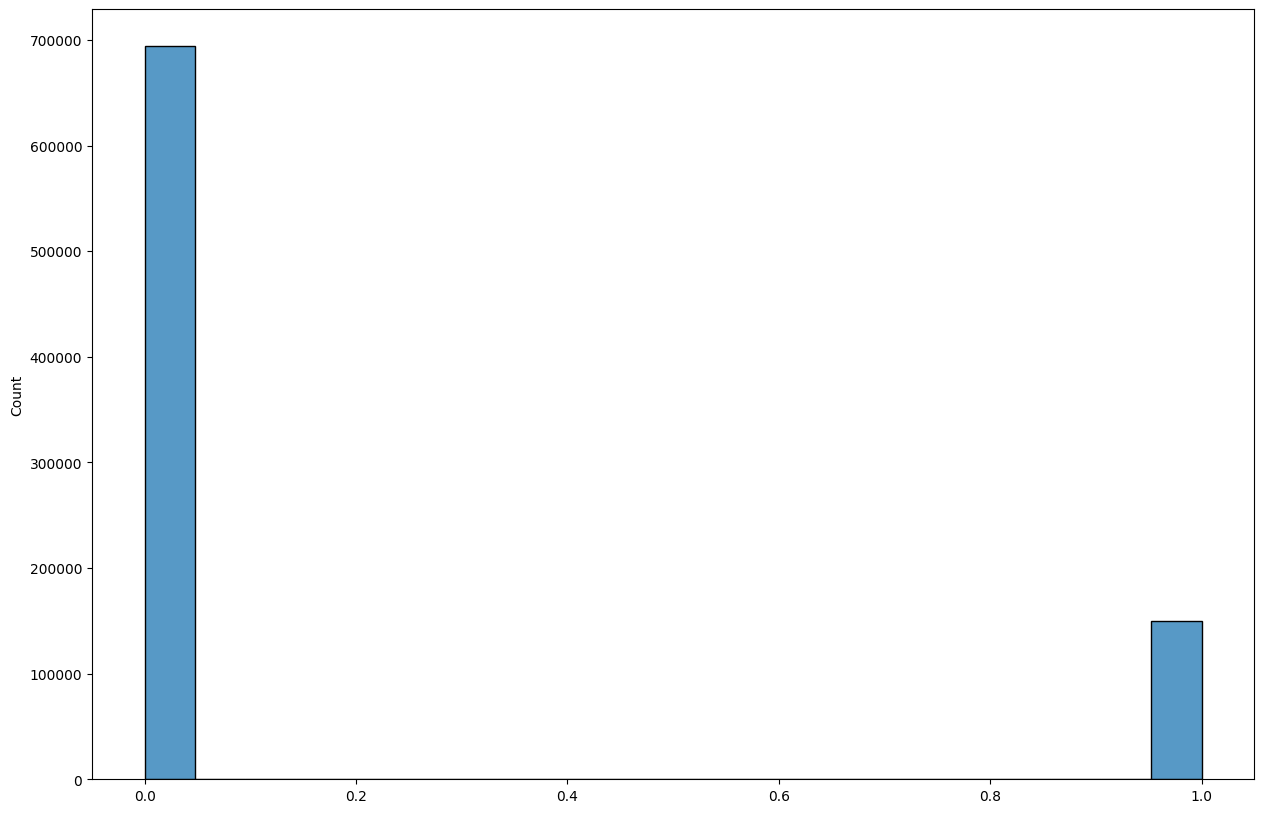

In [ ]:
# 종속 변수 데이터 분포 확인
plt.figure(figsize = (15,10))
sns.histplot(df_1516['loan_status'].tolist())
plt.show()

0인 변수가 1인 변수보다 압도적으로 많음을 확인했습니다. 이에 1인 변수를 소수 또는 이상치로 생각해보았습니다.

그리고 각 변수에 대해 null값이 얼마 있는지 확인해보았습니다.

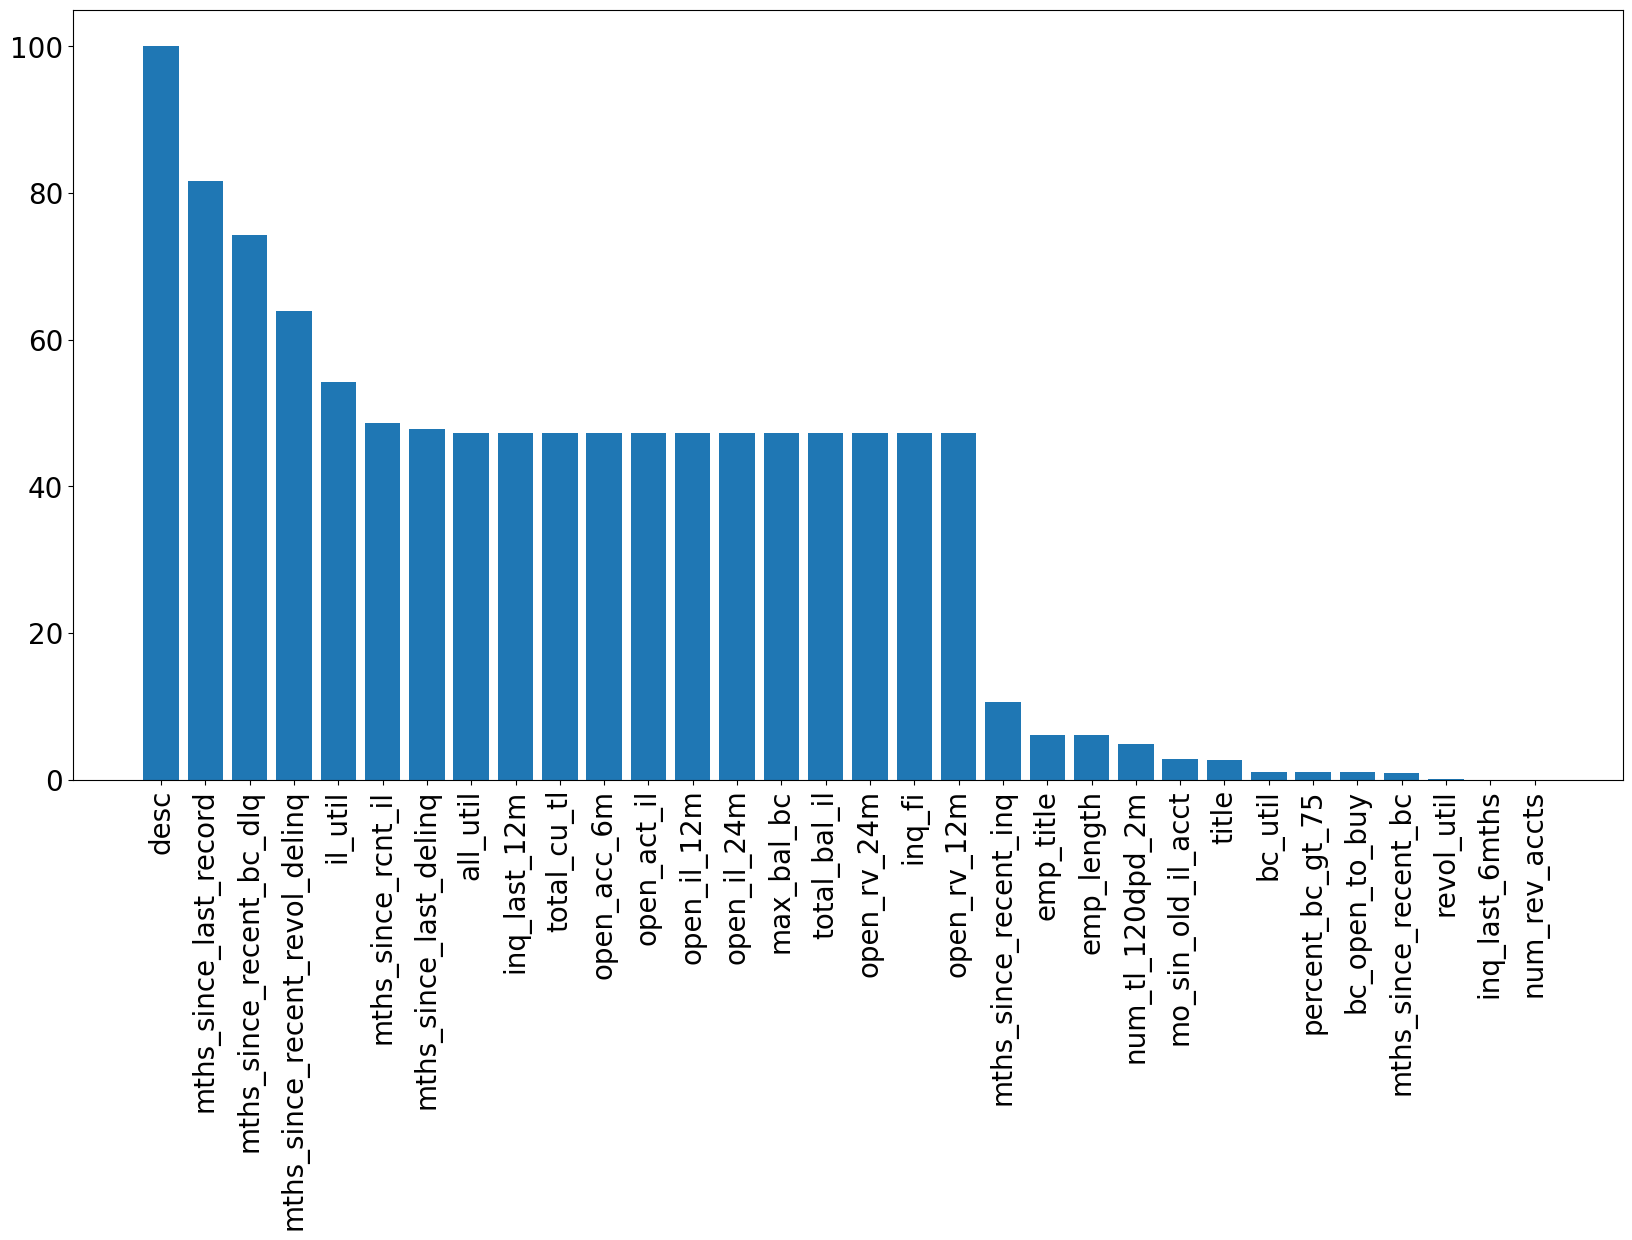

In [ ]:
percent_null_df_1516 = pd.DataFrame(zip(df_1516.columns,100*np.array(df_1516.isnull().sum().tolist())/len(df_1516)))
percent_null_df_1516.columns = ['col','how_many']
percent_null_df_1516 = percent_null_df_1516.sort_values(by='how_many', axis=0,ascending=False)

plt.figure(figsize = (20,10))
plt.rcParams.update({'font.size': 20})
plt.xticks(rotation=90)
plt.bar(percent_null_df_1516[percent_null_df_1516['how_many']>0]['col'], percent_null_df_1516[percent_null_df_1516['how_many']>0]['how_many'])
plt.show()

null 확인 결과 크게 결측치가 40%인 변수들과 그렇지 않은 변수들이 있습니다.

그래서 다음과 같은 작업을 진행하겠습니다.

1. 결측치가 20% 넘는 변수들의 경우 제거합니다.

2. 결측치가 20% 넘지않은 변수들의 경우 imputation 또는 표본 삭제 진행합니다.

In [ ]:
# 결측치 20% 넘는 변수 제거
df_1516 = df_1516.drop(percent_null_df_1516[percent_null_df_1516['how_many']>=20]['col'].tolist(), axis=1)
percent_null_df_1516 = pd.DataFrame(zip(df_1516.columns,100*np.array(df_1516.isnull().sum().tolist())/len(df_1516)))
percent_null_df_1516.columns = ['col','how_many']

# 나머지 결측치 있는 변수의 정보 확인
col_with_null = percent_null_df_1516[percent_null_df_1516['how_many']>0]['col'].tolist()
having_null = df_1516[col_with_null + ['loan_status']]
print(having_null.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843866 entries, 0 to 843865
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   emp_title              792526 non-null  object 
 1   emp_length             792875 non-null  object 
 2   title                  821528 non-null  object 
 3   inq_last_6mths         843865 non-null  float64
 4   revol_util             843446 non-null  float64
 5   bc_open_to_buy         835434 non-null  float64
 6   bc_util                834976 non-null  float64
 7   mo_sin_old_il_acct     820143 non-null  float64
 8   mths_since_recent_bc   835852 non-null  float64
 9   mths_since_recent_inq  754734 non-null  float64
 10  num_rev_accts          843865 non-null  float64
 11  num_tl_120dpd_2m       803404 non-null  float64
 12  percent_bc_gt_75       835128 non-null  float64
 13  loan_status            843866 non-null  int64  
dtypes: float64(10), int64(1), object(3)


결측치 작업 전에, 연속형 변수에서 최소와 최대가 같은 변수가 무엇인지 확인해보겠습니다.

최소와 최대가 같다면 하나의 상수로만 이뤄지고 있다는 의미이니 발견되면 삭제합니다.

In [ ]:
# describe 이용
describe_df = df_1516.describe()
describe_df = describe_df.T

# 최소 == 최대 찾기
print('최소와 최대가 같은 변수')
same_min_max = []
for idx in range(len(describe_df)):
    temp = describe_df.iloc[idx]
    mean,min_, q1, q3, max_ = temp[1], temp[3], temp[4], temp[6], temp[7]
    if min_ == max_:
        same_min_max.append(describe_df.index.tolist()[idx])
print(same_min_max)
df_1516 = df_1516.drop(same_min_max, axis = 1)

최소와 최대가 같은 변수
['policy_code']


object형 변수 / 숫자형 변수 구분해서 null에 따른 타 변수와 상관관계를 확인해보겠습니다.

In [ ]:
# object형 변수 / 숫자형 변수 구분하기
object_col_list = []
num_col_list = []

for i,j in zip(df_1516.columns, df_1516.dtypes):
  if 'object' == j:
    object_col_list.append(i)
  else:
    num_col_list.append(i)

In [ ]:
# null이 어떤 변수와 관련되어 있는지 확인하는 작업(오래 걸림!!!!!!!!!!!)
for col in col_with_null:
  temp_whose_null = df_1516[df_1516[col].isnull()]
  temp_whose_not_null = df_1516[df_1516[col].notnull()]
  for ob_col in object_col_list:
    if col == ob_col:
      continue
    twn1 = temp_whose_null[[ob_col]].value_counts()
    twn2 = temp_whose_not_null[[ob_col]].value_counts()
    twn1_key_list = list(dict(twn1).keys())
    twn2_key_list = list(dict(twn2).keys())
    if len(twn1) == 1:
      twn1_key_ele = twn1_key_list[0]
      if twn1_key_ele not in twn2_key_list:
        print(col, ob_col)
        print(twn1)
        print(' ')
    elif len(twn2) == 1:
      twn2_key_ele = twn2_key_list[0]
      if twn2_key_ele not in twn1_key_list:
        print(col, ob_col)
        print(twn2)
        print(' ')

  for num_col in num_col_list:
    if num_col == col:
      continue
    twn1 = temp_whose_null[num_col]
    twn2 = temp_whose_not_null[num_col]
    min_twn1 = min(twn1)
    min_twn2 = min(twn2)
    max_twn1 = max(twn1)
    max_twn2 = max(twn2)
    if min_twn1 == max_twn1:
      if (twn1.describe()[0] > 1) and ((min_twn1 < min_twn2) or (min_twn1 > max_twn2)):
        print(col, num_col)
        print(twn1.describe())
        print(' ')
    elif min_twn2 == max_twn2 :
      if (twn2.describe()[0] > 1) and ((min_twn2 < min_twn1) or (min_twn2 > max_twn1)):
        print(col, num_col)
        print(twn2.describe())
        print(' ')

inq_last_6mths url
url                                                              
https://lendingclub.com/browse/loanDetail.action?loan_id=69266577    1
dtype: int64
 
num_rev_accts url
url                                                              
https://lendingclub.com/browse/loanDetail.action?loan_id=63407533    1
dtype: int64
 
percent_bc_gt_75 total_bc_limit
count    8738.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: total_bc_limit, dtype: float64
 


결측치와 상관관계 있는 변수들은 다음과 같게 나왔습니다.

inq_last_6mths
- url

num_rev_accts
- url

percent_bc_gt_75
- total_bc_limit

url                                                              
https://lendingclub.com/browse/loanDetail.action?loan_id=69266577    1
dtype: int64
 
url                                                              
https://lendingclub.com/browse/loanDetail.action?loan_id=63407533    1
dtype: int64
 
total_bc_limit
0.0               8738
dtype: int64


<Axes: xlabel='percent_bc_gt_75', ylabel='total_bc_limit'>

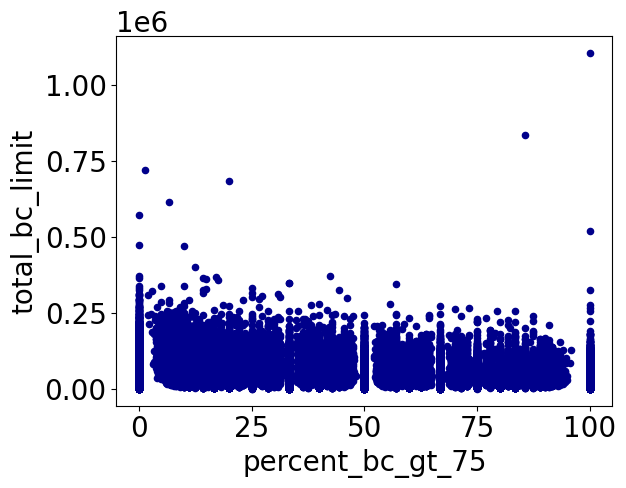

In [ ]:
print(df_1516[df_1516['inq_last_6mths'].isnull()][['url']].value_counts())
print(' ')
print(df_1516[df_1516['num_rev_accts'].isnull()][['url']].value_counts())
print(' ')
print(df_1516[df_1516['percent_bc_gt_75'].isnull()][['total_bc_limit']].value_counts())
df_1516[df_1516['percent_bc_gt_75'].notnull()][['percent_bc_gt_75','total_bc_limit']].plot.scatter(x='percent_bc_gt_75', y='total_bc_limit', c='DarkBlue')

위를 통해 알 수 있는 정보는 다음과 같습니다.

1. url은 쓸모가 없다. (애초에 접속도 안 된다.)

2. 은행카드 비율 75% 이상인지 아닌지에 따라 한도가 영향을 받는다.

그리고 나머지 결측치 있는 변수들의 정보를 확인하고 각각에 맞는 조치를 취하겠습니다.

In [ ]:
# url 제외
df_1516 = df_1516.drop(['url'], axis=1)

# percent_bc_gt_75에서 결측값은 역시 비중이 0으로 대체 / AI가 total_bc_limit와 연계할 것으로 생각
df_1516[['percent_bc_gt_75']] = df_1516[['percent_bc_gt_75']].fillna(0)
col_with_null.remove('percent_bc_gt_75')

In [ ]:
# emp_title, title 확인
print('emp_title 확인')
print(df_1516[['emp_title']].value_counts().sort_values())
print(' ')
print('title 확인')
print(df_1516[['title']].value_counts().sort_values())

# emp_title 제외 - President, Partner같은 장난성 정보가 있고 purpose에 비해 애매한 것들이 있기에 변수 제외
# title 제외 - Trying to come back to reality! 같은 장난성 정보가 있고 Other같은 애매한 것들이 있기에 변수 제외
df_1516 = df_1516.drop(['emp_title','title'], axis=1)
col_with_null.remove('emp_title')
col_with_null.remove('title')

emp_title 확인
emp_title                            
Sr. Developer / Tech Director                1
Director of Hospitality & Stewardship        1
Director of Marketing and Operations         1
Director of HVAC Sales                       1
Director of Growth & Development             1
                                         ...  
RN                                        6351
Registered Nurse                          6514
Owner                                     8733
Manager                                  14011
Teacher                                  15992
Length: 208138, dtype: int64
 
title 확인
title                                  
considerate                                     1
Credit Card/Auto Repair                         1
DebtC                                           1
Learning and training                           1
Pay off Lowes Card                              1
Paying off higher interest cards & auto         1
Prescription Drug and Medical Costs             1
Ne

In [ ]:
# emp_length 확인
print('emp_length 확인')
print(df_1516['emp_length'].value_counts())

# emp_length의 경우 숫자 정보가 있으므로 숫자로 encode / 결측값은 0으로 대체(a.k.a 무직)
df_1516['emp_length'] = df_1516['emp_length'].str.split(' ',expand=True).replace(['<']+list(range(10))+['10+'], [0]+list(range(10))+[10]).iloc[:,0]
df_1516[['emp_length']] = df_1516[['emp_length']].fillna(0)
col_with_null.remove('emp_length')
df_1516[['emp_length']] = df_1516[['emp_length']].astype(int)

emp_length 확인
10+ years    287582
2 years       76073
3 years       67288
< 1 year      65403
1 year        55932
5 years       50697
4 years       49618
8 years       39827
6 years       35020
9 years       33189
7 years       32246
Name: emp_length, dtype: int64


inq_last_6mths, mths_since_recent_inq, num_tl_120dpd_2m은 정수형 변수입니다. 또한, 기간이 정해져 있으므로 결측치에 대해 0으로 대체할 수 있다고 판단하였습니다.

In [ ]:
# inq_last_6mths, mths_since_recent_inq에서 결측값은 문의(Inquiry)가 없다는 것으로 간주 -> 0으로 대체
df_1516[['inq_last_6mths','mths_since_recent_inq']] = df_1516[['inq_last_6mths','mths_since_recent_inq']].fillna(0)
col_with_null.remove('inq_last_6mths')
col_with_null.remove('mths_since_recent_inq')

# num_tl_120dpd_2m에서 결측값은 계좌가 없다고 간주 -> 0으로 대체
df_1516[['num_tl_120dpd_2m']] = df_1516[['num_tl_120dpd_2m']].fillna(0)
col_with_null.remove('num_tl_120dpd_2m')

In [ ]:
# 나머지 결측치는 scatter 그리면서 확인하기
df_1516[col_with_null+['loan_status']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843866 entries, 0 to 843865
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   revol_util            843446 non-null  float64
 1   bc_open_to_buy        835434 non-null  float64
 2   bc_util               834976 non-null  float64
 3   mo_sin_old_il_acct    820143 non-null  float64
 4   mths_since_recent_bc  835852 non-null  float64
 5   num_rev_accts         843865 non-null  float64
 6   loan_status           843866 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 45.1 MB


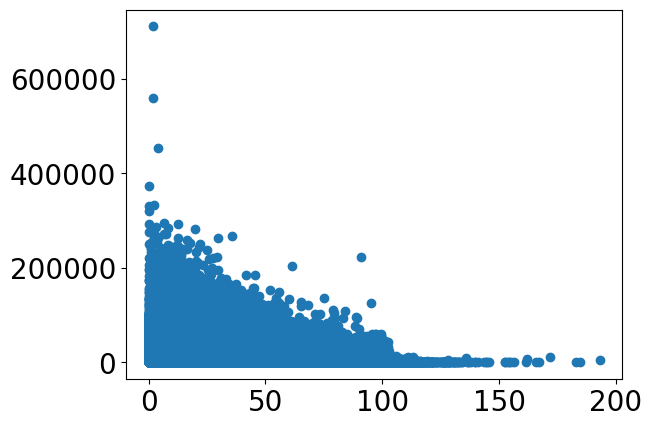

In [ ]:
plt.scatter(df_1516[col_with_null+['loan_status']][['revol_util']], df_1516[col_with_null+['loan_status']][['bc_open_to_buy']])
plt.show()

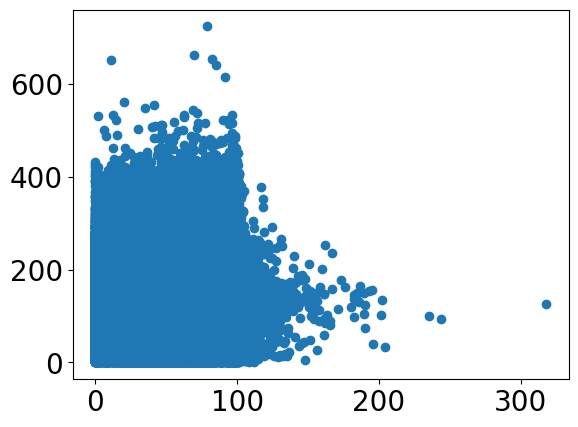

In [ ]:
plt.scatter(df_1516[col_with_null+['loan_status']][['bc_util']], df_1516[col_with_null+['loan_status']][['mo_sin_old_il_acct']])
plt.show()

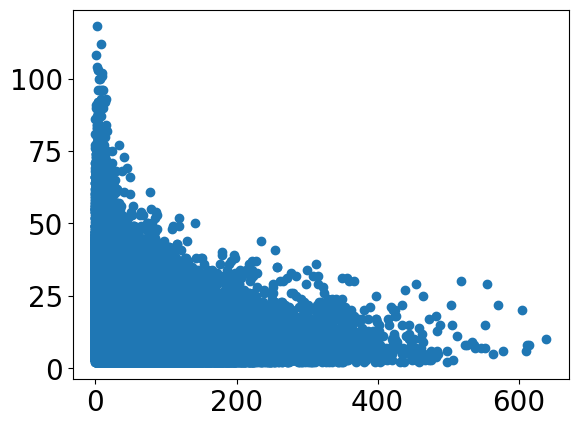

In [ ]:
plt.scatter(df_1516[col_with_null+['loan_status']][['mths_since_recent_bc']], df_1516[col_with_null+['loan_status']][['num_rev_accts']])
plt.show()

나머지 변수인 revol_util, bc_open_to_buy, bc_util, mo_sin_old_il_acct, mths_since_recent_bc, num_rev_accts 등은 실수형 변수이므로 knn imputation을 진행합니다.

imputation을 진행하기 전에 object 타입 변수가 있는지 확인해봅니다.

In [ ]:
df_1516.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843866 entries, 0 to 843865
Data columns (total 62 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          843866 non-null  int64  
 1   loan_amnt                   843866 non-null  float64
 2   funded_amnt                 843866 non-null  float64
 3   funded_amnt_inv             843866 non-null  float64
 4   term                        843866 non-null  object 
 5   installment                 843866 non-null  float64
 6   emp_length                  843866 non-null  int64  
 7   home_ownership              843866 non-null  object 
 8   annual_inc                  843866 non-null  float64
 9   verification_status         843866 non-null  object 
 10  issue_d                     843866 non-null  object 
 11  loan_status                 843866 non-null  int64  
 12  purpose                     843866 non-null  object 
 13  zip_code      

In [ ]:
print(df_1516[['term']].value_counts()) # 36, 60으로 전환
print(df_1516[['home_ownership']].value_counts()) # one-hot encoding
print(df_1516[['verification_status']].value_counts()) # one-hot encoding
print(df_1516[['issue_d']].value_counts()) # 월과 년으로 분리
print(df_1516[['purpose']].value_counts()) # one-hot encoding
print(df_1516[['zip_code']].value_counts()) # addr_state 삭제 후 zip_code로 통일
print(df_1516[['addr_state']].value_counts()) # 삭제
print(df_1516[['earliest_cr_line']].value_counts()) # 월과 년으로 분리
print(df_1516[['initial_list_status']].value_counts()) # one-hot encoding
print(df_1516[['disbursement_method']].value_counts()) # one-hot encoding

term      
 36 months    600134
 60 months    243732
dtype: int64
home_ownership
MORTGAGE          411686
RENT              334197
OWN                97871
ANY                  112
dtype: int64
verification_status
Source Verified        362336
Verified               243871
Not Verified           237659
dtype: int64
issue_d 
Mar-2016    60234
Oct-2015    48495
Jul-2015    45903
Dec-2015    43999
Feb-2016    38704
Nov-2015    37265
Aug-2016    36044
Aug-2015    35827
Apr-2016    35679
Apr-2015    35391
Jan-2015    35079
Jul-2016    34527
Dec-2016    34463
Nov-2016    32843
Jun-2016    32707
Jan-2016    31896
May-2015    31879
Oct-2016    31585
Sep-2015    28591
Jun-2015    28438
May-2016    27620
Sep-2016    27591
Mar-2015    25368
Feb-2015    23738
dtype: int64
purpose           
debt_consolidation    491148
credit_card           191410
home_improvement       55801
other                  47217
major_purchase         17720
medical                 9264
car                     8213
small_b

In [ ]:
# term 36, 60으로 전환
new_temp_df = pd.DataFrame(df_1516['term'].str.split(' ',expand=True))
new_temp_df.columns = ['non0','mon','non1']
new_temp_df = new_temp_df.astype({'mon':'int32'})
df_1516[['term']] = new_temp_df[['mon']]

# home_ownership - one-hot encoding
df_1516 = pd.concat([df_1516,pd.get_dummies(df_1516[['home_ownership']], drop_first=True)], axis= 1)
df_1516 = df_1516.drop('home_ownership', axis=1)

# verification_status - one-hot encoding
df_1516 = pd.concat([df_1516,pd.get_dummies(df_1516[['verification_status']], drop_first=True)], axis= 1)
df_1516 = df_1516.drop('verification_status', axis=1)

# 'issue_d' # 월과 년으로 분리
new_temp_df = pd.DataFrame(df_1516['issue_d'].str.split('-',expand=True))
new_temp_df.columns = ['issue_month','issue_year']
new_temp_df = new_temp_df.astype({'issue_year':'int32'})
new_temp_df[['issue_month']] = new_temp_df[['issue_month']].replace(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], list(range(1,13)))
new_temp_df = new_temp_df.astype({'issue_month':'int32'})

df_1516 = pd.concat([df_1516,new_temp_df], axis= 1)
df_1516 = df_1516.drop('issue_d', axis=1)

# purpose - one-hot encoding
df_1516 = pd.concat([df_1516,pd.get_dummies(df_1516[['purpose']], drop_first=True)], axis= 1)
df_1516 = df_1516.drop('purpose', axis=1)

# addr_state 삭제 후 zip_code로 통일
new_temp_df = pd.DataFrame(df_1516['zip_code'].str.split('x',expand=True))
new_temp_df = new_temp_df.iloc[:,0]
new_temp_df = new_temp_df.astype(int)

df_1516 = pd.concat([df_1516,new_temp_df], axis= 1)
df_1516 = df_1516.drop(['zip_code','addr_state'], axis=1)
df_1516.columns = df_1516.columns[:-1].tolist() + ['new_zip_code']

# 'earliest_cr_line' # 월과 년으로 분리
new_temp_df = pd.DataFrame(df_1516['earliest_cr_line'].str.split('-',expand=True))
new_temp_df.columns = ['earliest_cr_line_month','earliest_cr_line_year']
new_temp_df = new_temp_df.astype({'earliest_cr_line_year':'int32'})
new_temp_df[['earliest_cr_line_month']] = new_temp_df[['earliest_cr_line_month']].replace(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], list(range(1,13)))
new_temp_df = new_temp_df.astype({'earliest_cr_line_month':'int32'})

df_1516 = pd.concat([df_1516,new_temp_df], axis= 1)
df_1516 = df_1516.drop('earliest_cr_line', axis=1)

# initial_list_status - one-hot encoding
df_1516 = pd.concat([df_1516,pd.get_dummies(df_1516[['initial_list_status']], drop_first=True)], axis= 1)
df_1516 = df_1516.drop('initial_list_status', axis=1)

# disbursement_method - one-hot encoding
df_1516 = pd.concat([df_1516,pd.get_dummies(df_1516[['disbursement_method']], drop_first=True)], axis= 1)
df_1516 = df_1516.drop('disbursement_method', axis=1)

이제 나머지 변수들을 Imputation을 진행할 것입니다.

각 변수들의 상관관계를 확인해보았을 때 머신러닝을 이용해서 진행하려고 합니다.

In [ ]:
# 각 결측치 있는 변수들의 상관관계를 보았을 때 나쁘지 않은 결과가 나와서 머신러닝으로 대체해보기
dropna_df_1516 = df_1516.dropna()
isna_any_df_1516 = df_1516[df_1516.isna().any(axis=1)]
corr_df_1516 = dropna_df_1516.corr()
print(corr_df_1516[['revol_util']].sort_values('revol_util'))
print(corr_df_1516[['bc_open_to_buy']].sort_values('bc_open_to_buy'))
print(corr_df_1516[['bc_util']].sort_values('bc_util'))
print(corr_df_1516[['mo_sin_old_il_acct']].sort_values('mo_sin_old_il_acct'))
print(corr_df_1516[['mths_since_recent_bc']].sort_values('mths_since_recent_bc'))
print(corr_df_1516[['num_rev_accts']].sort_values('num_rev_accts'))

                       revol_util
bc_open_to_buy          -0.467577
acc_open_past_24mths    -0.230935
num_tl_op_past_12m      -0.220630
num_op_rev_tl           -0.219043
num_rev_accts           -0.199231
...                           ...
mo_sin_rcnt_rev_tl_op    0.193653
revol_bal                0.244821
percent_bc_gt_75         0.725580
bc_util                  0.851818
revol_util               1.000000

[78 rows x 1 columns]
                       bc_open_to_buy
bc_util                     -0.536360
revol_util                  -0.467577
percent_bc_gt_75            -0.435618
earliest_cr_line_year       -0.160614
mths_since_recent_bc        -0.116060
...                               ...
num_bc_tl                    0.430699
num_bc_sats                  0.467753
total_rev_hi_lim             0.587909
total_bc_limit               0.822113
bc_open_to_buy               1.000000

[78 rows x 1 columns]
                       bc_util
bc_open_to_buy       -0.536360
total_bc_limit       -0.2290

상관관계가 어느정도 있는 것을 확인했으니 sklearn의 Imputation을 이용해도 된다는 결론을 얻었습니다. 그래서 IterativeImputer을 이용했습니다.

In [ ]:
# IterativeImputer (오래걸림!!!!)
imp_mean = IterativeImputer(random_state=0)
df_1516_imputed = imp_mean.fit_transform(df_1516)
df_1516_imputed = pd.DataFrame(df_1516_imputed)
df_1516_imputed.columns = df_1516.columns.tolist()

In [ ]:
df_1516_imputed

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,annual_inc,loan_status,dti,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,new_zip_code,earliest_cr_line_month,earliest_cr_line_year,initial_list_status_w,disbursement_method_DirectPay
0,68407277.0,3600.0,3600.0,3600.0,36.0,123.03,10.0,55000.0,0.0,5.91,...,0.0,0.0,0.0,0.0,0.0,190.0,8.0,2003.0,1.0,0.0
1,68355089.0,24700.0,24700.0,24700.0,36.0,820.28,10.0,65000.0,0.0,16.06,...,0.0,0.0,1.0,0.0,0.0,577.0,12.0,1999.0,1.0,0.0
2,66310712.0,35000.0,35000.0,35000.0,60.0,829.90,10.0,110000.0,0.0,17.06,...,0.0,0.0,0.0,0.0,0.0,76.0,9.0,2008.0,1.0,0.0
3,68476807.0,10400.0,10400.0,10400.0,60.0,289.91,3.0,104433.0,0.0,25.37,...,0.0,0.0,0.0,0.0,0.0,174.0,6.0,1998.0,1.0,0.0
4,68426831.0,11950.0,11950.0,11950.0,36.0,405.18,4.0,34000.0,0.0,10.20,...,0.0,0.0,0.0,0.0,0.0,300.0,10.0,1987.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843861,89885898.0,24000.0,24000.0,24000.0,60.0,543.50,7.0,95000.0,0.0,19.61,...,0.0,0.0,0.0,0.0,0.0,356.0,12.0,1999.0,0.0,0.0
843862,88977788.0,24000.0,24000.0,24000.0,60.0,515.74,10.0,108000.0,0.0,34.94,...,0.0,0.0,0.0,0.0,0.0,840.0,2.0,1991.0,0.0,0.0
843863,88985880.0,40000.0,40000.0,40000.0,60.0,859.56,9.0,227000.0,0.0,12.75,...,0.0,0.0,0.0,0.0,0.0,907.0,2.0,1995.0,0.0,0.0
843864,88224441.0,24000.0,24000.0,24000.0,60.0,564.56,6.0,110000.0,1.0,18.30,...,0.0,0.0,0.0,0.0,0.0,334.0,7.0,1999.0,0.0,0.0


In [ ]:
# Imputation 후 데이터 다시 저장
df_1516_imputed.to_csv('/content/drive/MyDrive/imputed_1516.csv', index=False)

In [4]:
# 저장된 Imputation 데이터다시 불러오기
df_revised = pd.read_csv('/content/drive/MyDrive/imputed_1516.csv')

이제 변수들의 분포 확인해보겠습니다.

In [ ]:
# 변수확인 (오래걸림!!)
new_col_df = df_revised.columns
print(len(new_col_df))
for idx in range(len(new_col_df)//6):
  if idx == len(new_col_df) - 1:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), constrained_layout = True)
    ax1.scatter(df_revised[new_col_df[idx*6]], df_revised[new_col_df[idx*6+1]], c=df_revised['loan_status'], cmap='viridis')
    ax1.set_xlabel(new_col_df[idx*6])
    ax1.set_ylabel(new_col_df[idx*6+1])
    ax2.scatter(df_revised[new_col_df[idx*6+2]], df_revised[new_col_df[idx*6+2]], c=df_revised['loan_status'], cmap='viridis')
    ax2.set_xlabel(new_col_df[idx*6+2])
    ax2.set_ylabel(new_col_df[idx*6+2])
    ax3.scatter(df_revised[new_col_df[idx*6+2]], df_revised[new_col_df[idx*6+2]], c=df_revised['loan_status'], cmap='viridis')
    ax3.set_xlabel(new_col_df[idx*6+2])
    ax3.set_ylabel(new_col_df[idx*6+2])
    plt.show()
  else:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), constrained_layout = True)
    ax1.scatter(df_revised[new_col_df[idx*6]], df_revised[new_col_df[idx*6+1]], c=df_revised['loan_status'], cmap='viridis')
    ax1.set_xlabel(new_col_df[idx*6])
    ax1.set_ylabel(new_col_df[idx*6+1])
    ax2.scatter(df_revised[new_col_df[idx*6+2]], df_revised[new_col_df[idx*6+3]], c=df_revised['loan_status'], cmap='viridis')
    ax2.set_xlabel(new_col_df[idx*6+2])
    ax2.set_ylabel(new_col_df[idx*6+3])
    ax3.scatter(df_revised[new_col_df[idx*6+4]], df_revised[new_col_df[idx*6+5]], c=df_revised['loan_status'], cmap='viridis')
    ax3.set_xlabel(new_col_df[idx*6+4])
    ax3.set_ylabel(new_col_df[idx*6+5])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

확인 결과 BoxPlot, DBSCAN, Isolation Forest, One-Class SVM 등 기존 Outlier Detection으로 소수점(이상치)들을 찾기 어려웠습니다.

왜냐하면 모든 변수들이 소수점들이 다수점 안에 포함되어 있기 때문입니다.

따라서 기존 Outlier Detection 방법론들은 해당 문제를 해결하기 적합한 방법론들은 아니라고 생각했습니다.

또한, 0 초과를 1 / 0 이하를 0으로 만들고 그에 따른 상관관계도 체크해봤습니다.

In [ ]:
# 0 초과를 1 / 0 이하를 0으로 만들고 그에 따른 상관관계 체크
one_df = pd.DataFrame(np.array(torch.tensor(torch.tensor(np.array(df_revised)) > 0).type(torch.int32)))
one_df.columns = df_revised.columns
corr_one_df = one_df.corr()

print(corr_one_df[corr_one_df.iloc[:,-1] < -0.1].iloc[:,-1])
print(corr_one_df[corr_one_df.iloc[:,-1] > 0.1].iloc[:,-1])
in_corr_zero = corr_one_df[corr_one_df.iloc[:,-1] < -0.1].iloc[:,-1].index.tolist()

Series([], Name: disbursement_method_DirectPay, dtype: float64)
disbursement_method_DirectPay    1.0
Name: disbursement_method_DirectPay, dtype: float64


상관관계 확인 결과 절대값이 0.15를 넘기는 변수가 없었습니다. 따라서 상관계수는 변수 선택하는데 큰 도움이 되지 않는다고 생각했습니다.

또한 데이터를 확인했을 때 특정 row에서 튀는 값들이 발견되었지만, 그것이 곧 TARGET == 1로 이어지지 않음을 확인하였습니다.

따라서 어떠한 정보 없이 무조건적으로 튀는 값들을 지우지는 않기로 했습니다.

훈련데이터 : 검증데이터 = 8 : 2 로 나누기

In [6]:
X_train, X_val, y_train, y_val = train_test_split(df_revised.drop('loan_status', axis=1), df_revised[['loan_status']], test_size=0.2, random_state=42, stratify = df_revised['loan_status'].tolist())

수가 지나치게 높은 데이터가 존재해서 표준화를 진행했습니다.

In [7]:
scaler = StandardScaler()
temp_11 = X_train.columns.tolist()
temp_12 = X_train.index.tolist()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_train.columns = temp_11
X_train.index = temp_12

temp_21 = X_val.columns.tolist()
temp_22 = X_val.index.tolist()
X_val = pd.DataFrame(scaler.transform(X_val))
X_val.columns = temp_21
X_val.index = temp_22

먼저 SMOTE 등 OverSampling, UnderSampling를 진행하기 전에 불균형 데이터로 가능한지 확인하기 위한 작업을 거쳤습니다. 머신러닝의 경우 Class Weight를 통해 조절했습니다.

그리고 모델간의 비교를 위해 X_val, y_val인 Validation Data로 측정했습니다.

In [8]:
df_revised['loan_status'].value_counts()

0.0    694282
1.0    149584
Name: loan_status, dtype: int64

# **3. 초기 상태에서 모델 학습**

지금까지 한 데이터를 바탕으로 모델 학습을 시도하고자 합니다. 다만, 데이터 불균형 때문에 Class Weight를 65:14로 지정했습니다

DecisionTreeClassifier / Original Data
F1 Score: 0.538742949376847
Precision Score: 0.2358085854252581
Recall Score: 0.2847879132265936
Confusion Matrix
[[111246  27611]
 [ 21397   8520]]


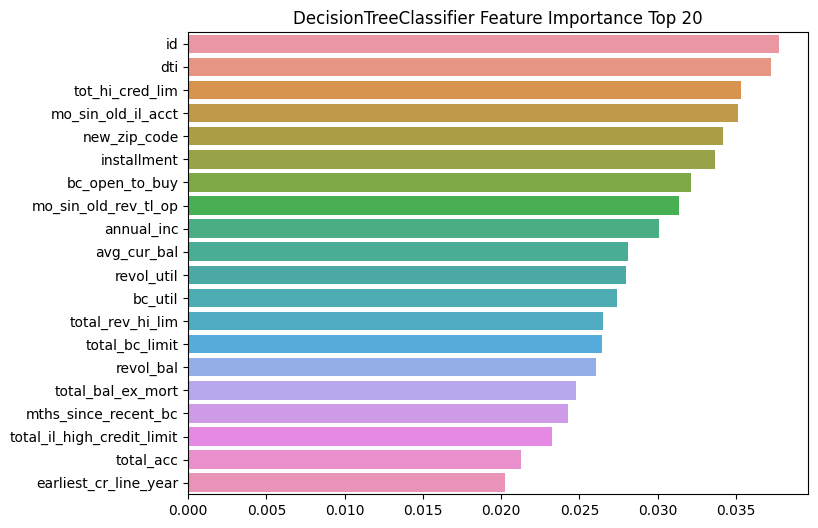

In [ ]:
# DecisionTreeClassifier
dtc = DecisionTreeClassifier(ccp_alpha=0.0, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        random_state=123, splitter='best', class_weight = {0: 65, 1: 14})
# class_weight 존재
dtc.fit(X_train, y_train)
print('DecisionTreeClassifier / Original Data')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), dtc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), dtc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), dtc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), dtc.predict(X_val)))

# DecisionTreeClassifier feature importance
dtc_ft_importance_values = dtc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
dtc_ft_series = pd.Series(dtc_ft_importance_values, index = X_train.columns)
dtc_ft_top20 = dtc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('DecisionTreeClassifier Feature Importance Top 20')
sns.barplot(x=dtc_ft_top20, y=dtc_ft_top20.index)
plt.show()

<ipython-input-10-0d740c8ecdff>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  etc.fit(X_train, y_train)


ExtraTreesClassifier / Original Data
F1 Score: 0.46899669008308326
Precision Score: 0.5125815470643057
Recall Score: 0.01838419627636461
Confusion Matrix
[[138334    523]
 [ 29367    550]]


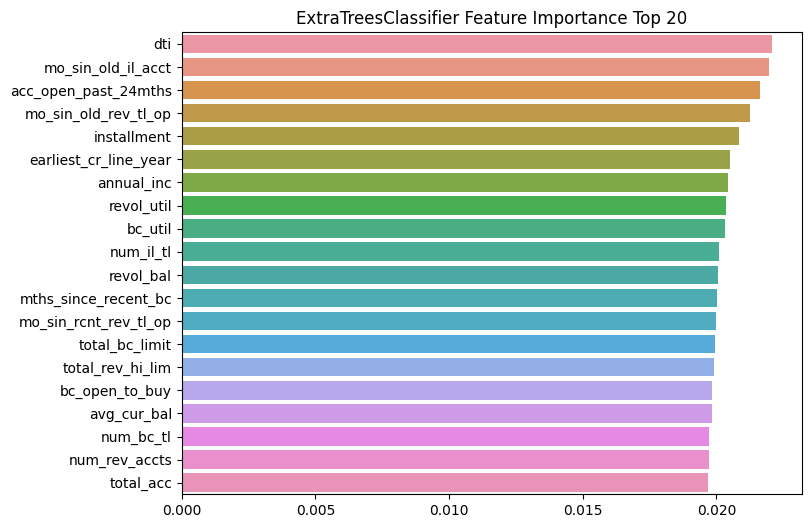

In [ ]:
# ExtraTreesClassifier
etc = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight = {0: 65, 1: 14},
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

etc.fit(X_train, y_train)
print('ExtraTreesClassifier / Original Data')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), etc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), etc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), etc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), etc.predict(X_val)))

# ExtraTreesClassifier feature importance
etc_ft_importance_values = etc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
etc_ft_series = pd.Series(etc_ft_importance_values, index = X_train.columns)
etc_ft_top20 = etc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('ExtraTreesClassifier Feature Importance Top 20')
sns.barplot(x=etc_ft_top20, y=etc_ft_top20.index)
plt.show()

<ipython-input-11-48a43dc38b28>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


RandomForestClassifier / Original Data
F1 Score: 0.49339401126043136
Precision Score: 0.463887065003283
Recall Score: 0.04723067152455126
Confusion Matrix
[[137224   1633]
 [ 28504   1413]]


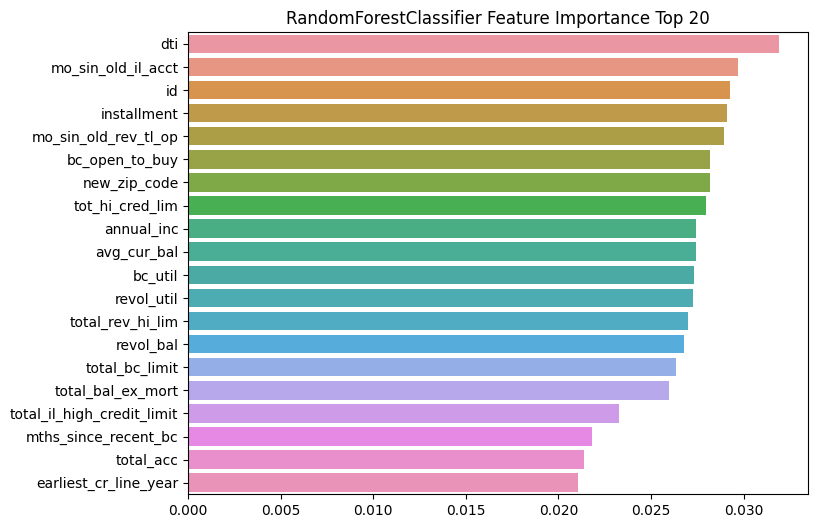

In [ ]:
# RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight = {0: 65, 1: 14},
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=-1, oob_score=False,
                        random_state=123, verbose=0, warm_start=False)
rfc.fit(X_train, y_train)
print('RandomForestClassifier / Original Data')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), rfc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), rfc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), rfc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), rfc.predict(X_val)))

# RandomForestClassifier feature importance
rfc_ft_importance_values = rfc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
rfc_ft_series = pd.Series(rfc_ft_importance_values, index = X_train.columns)
rfc_ft_top20 = rfc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('RandomForestClassifier Feature Importance Top 20')
sns.barplot(x=rfc_ft_top20, y=rfc_ft_top20.index)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119667, number of negative: 555425
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.428166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7000
[LightGBM] [Info] Number of data points in the train set: 675092, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044347 -> initscore=-3.070351
[LightGBM] [Info] Start training from score -3.070351
LGBMClassifier / Original Data
F1 Score: 0.4515093773755884
Precision Score: 0.5714285714285714
Recall Score: 0.00013370324564628805
Confusion Matrix
[[138854      3]
 [ 29913      4]]


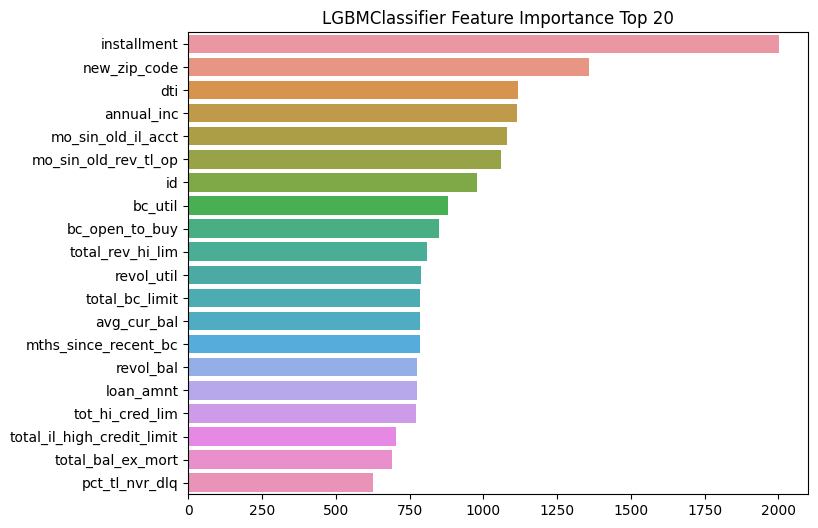

In [ ]:
# LGBMClassifier
lgmc = lightgbm.LGBMClassifier(boosting_type='gbdt', class_weight = {0: 65, 1: 14}, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.05, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
                random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0)
lgmc.fit(X_train, y_train)
print('LGBMClassifier / Original Data')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), lgmc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), lgmc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), lgmc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), lgmc.predict(X_val)))

# LGBMClassifier feature importance
lgmc_ft_importance_values = lgmc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
lgmc_ft_series = pd.Series(lgmc_ft_importance_values, index = X_train.columns)
lgmc_ft_top20 = lgmc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('LGBMClassifier Feature Importance Top 20')
sns.barplot(x=lgmc_ft_top20, y=lgmc_ft_top20.index)
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:48:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "eval_metirc" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier / Original Data
F1 Score: 0.503078919797702
Precision Score: 0.5426307448494453
Recall Score: 0.05722498913661129
Confusion Matrix
[[137414   1443]
 [ 28205   1712]]


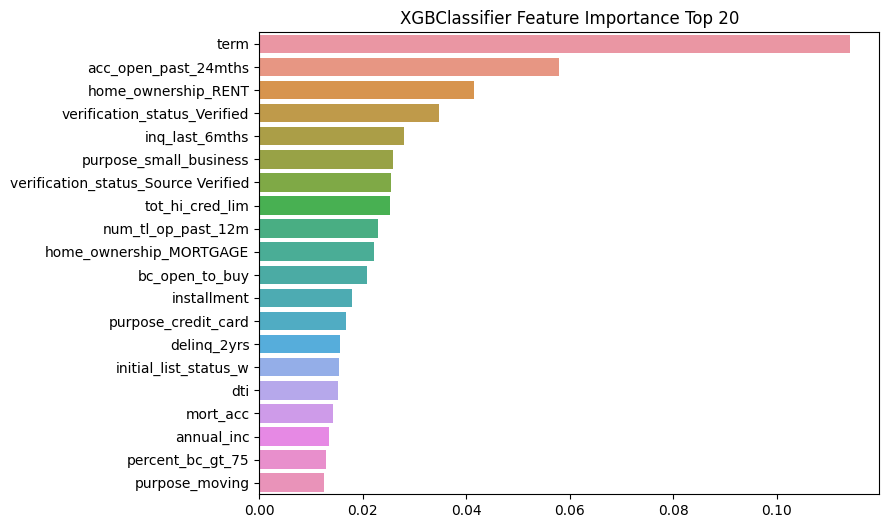

In [ ]:
# XGBClassifier
xgbc = XGBClassifier(booster='gbtree', device='gpu',objective='binary:logistic',
                     class_weight = {0: 65, 1: 14}, n_estimators = 1000,
                     min_child_weight = 2, eval_metirc = 'error',
                     learning_rate = 0.05, max_depth = 7, random_state=123)
xgbc.fit(X_train, y_train)
print('XGBClassifier / Original Data')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), xgbc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), xgbc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), xgbc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), xgbc.predict(X_val)))

# XGBClassifier feature importance
xgbc_ft_importance_values = xgbc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
xgbc_ft_series = pd.Series(xgbc_ft_importance_values, index = X_train.columns)
xgbc_ft_top20 = xgbc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('XGBClassifier Feature Importance Top 20')
sns.barplot(x=xgbc_ft_top20, y=xgbc_ft_top20.index)
plt.show()

# **4. OverSampling 후 모델 학습**

OverSampling은 여러가지 기법이 있지만, ADASYN을 도입하기로 했습니다. 소수점 관측치에 대해서 주변에 다수점이 많을 수록 더 많이 oversampling 하는 방법이라고 생각해 채택하였습니다. Border-line SMOTE는 보더라인에 가까우면 동일하게 샘플링을 많이 하지만, ADASYN은 주변 다수점(즉, 거리)에 따라서 샘플링 수가 달라집니다.

OverSampling은 Train Data 한해서만 진행했습니다. 또한, 모델간의 비교를 위해 X_val, y_val인 Validation Data로 그대로 측정했습니다.

In [8]:
adasyn = ADASYN(random_state=42)
#X_train, X_val, y_train, y_val에서 X_train, y_train으로 OverSampling
X_ads, y_ads = adasyn.fit_resample(X_train, y_train)
print(len(y_ads[y_ads['loan_status'] == 0]),len(y_ads[y_ads['loan_status'] == 1]))

555425 590462


OverSampling 데이터인 상태 / Pycaret을 이용한 최적의 Classification 모델 생성

DecisionTreeClassifier / OverSampling
F1 Score: 0.5327836686370351
Precision Score: 0.22760290556900725
Recall Score: 0.2639302069057726
Confusion Matrix
[[112061  26796]
 [ 22021   7896]]


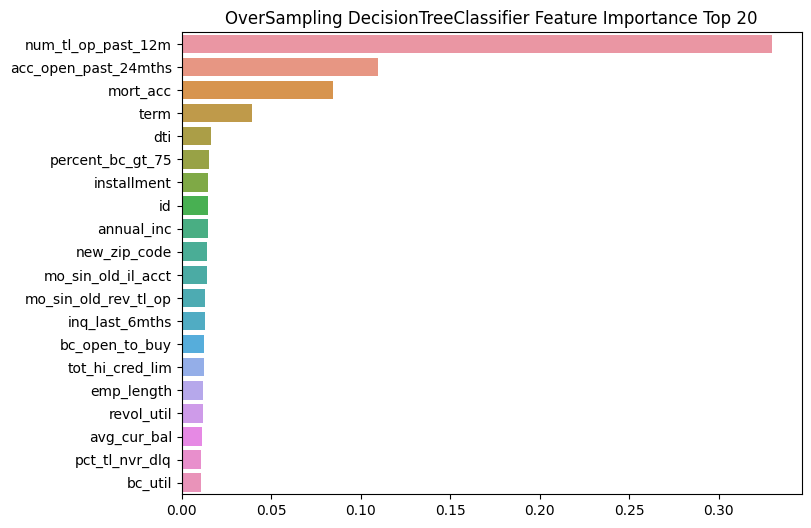

In [9]:
# OverSampling DecisionTreeClassifier
over_dtc = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        random_state=123, splitter='best')

over_dtc.fit(X_ads, y_ads)
print('DecisionTreeClassifier / OverSampling')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), over_dtc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), over_dtc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), over_dtc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), over_dtc.predict(X_val)))

# OverSampling DecisionTreeClassifier feature importance
over_dtc_ft_importance_values = over_dtc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
over_dtc_ft_series = pd.Series(over_dtc_ft_importance_values, index = X_train.columns)
over_dtc_ft_top20 = over_dtc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('OverSampling DecisionTreeClassifier Feature Importance Top 20')
sns.barplot(x=over_dtc_ft_top20, y=over_dtc_ft_top20.index)
plt.show()

<ipython-input-10-78cb586a27f2>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  over_etc.fit(X_ads, y_ads)


ExtraTreesClassifier / OverSampling
F1 Score: 0.5392691653988166
Precision Score: 0.38123711340206184
Recall Score: 0.12360865059999332
Confusion Matrix
[[132855   6002]
 [ 26219   3698]]


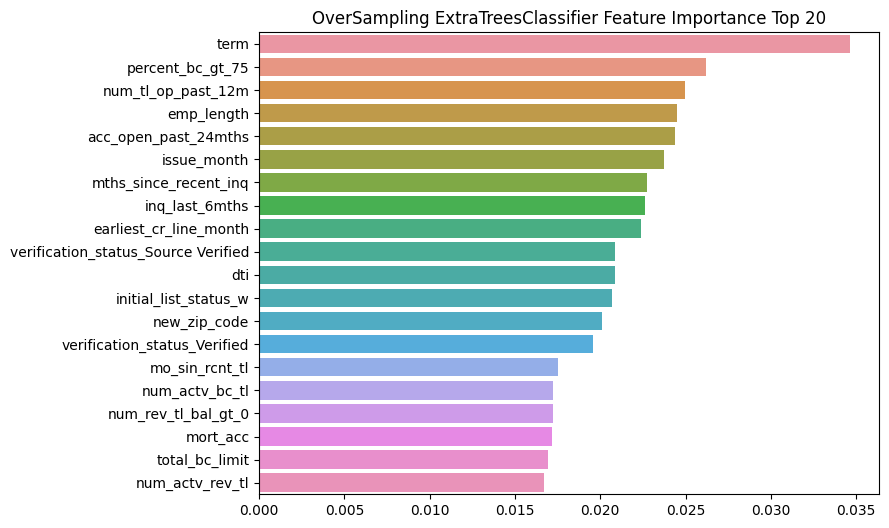

In [10]:
# OverSampling ExtraTreesClassifier
over_etc = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

over_etc.fit(X_ads, y_ads)
print('ExtraTreesClassifier / OverSampling')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), over_etc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), over_etc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), over_etc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), over_etc.predict(X_val)))

# OverSampling ExtraTreesClassifier feature importance
over_etc_ft_importance_values = over_etc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
over_etc_ft_series = pd.Series(over_etc_ft_importance_values, index = X_train.columns)
over_etc_ft_top20 = over_etc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('OverSampling ExtraTreesClassifier Feature Importance Top 20')
sns.barplot(x=over_etc_ft_top20, y=over_etc_ft_top20.index)
plt.show()

<ipython-input-11-959d57cf0d0d>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  over_rfc.fit(X_ads, y_ads)


RandomForestClassifier / OverSampling
F1 Score: 0.4885900617338308
Precision Score: 0.44651162790697674
Recall Score: 0.04171541264164188
Confusion Matrix
[[137310   1547]
 [ 28669   1248]]


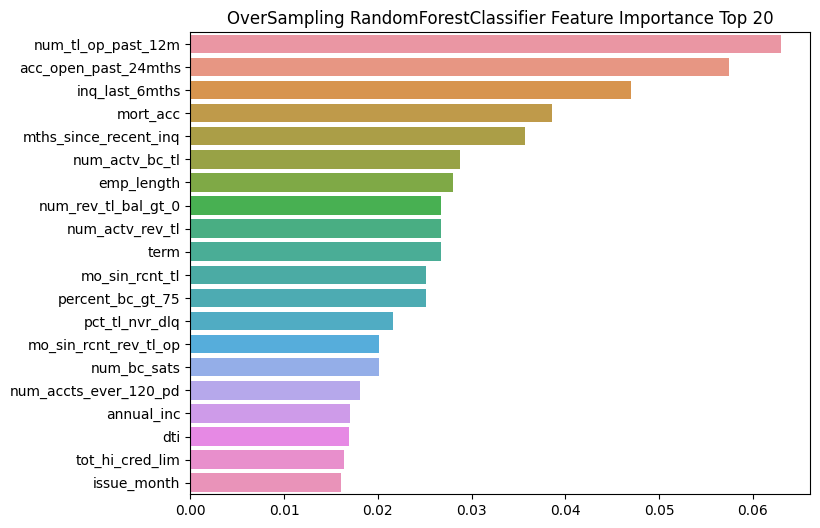

In [11]:
# OverSampling RandomForestClassifier
over_rfc = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=-1, oob_score=False,
                        random_state=123, verbose=0, warm_start=False)
over_rfc.fit(X_ads, y_ads)
print('RandomForestClassifier / OverSampling')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), over_rfc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), over_rfc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), over_rfc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), over_rfc.predict(X_val)))

# OverSampling RandomForestClassifier feature importance
over_rfc_ft_importance_values = over_rfc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
over_rfc_ft_series = pd.Series(over_rfc_ft_importance_values, index = X_train.columns)
over_rfc_ft_top20 = over_rfc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('OverSampling RandomForestClassifier Feature Importance Top 20')
sns.barplot(x=over_rfc_ft_top20, y=over_rfc_ft_top20.index)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 590462, number of negative: 555425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.086720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15967
[LightGBM] [Info] Number of data points in the train set: 1145887, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515288 -> initscore=0.061172
[LightGBM] [Info] Start training from score 0.061172
LGBMClassifier / OverSampling
F1 Score: 0.4730206131007699
Precision Score: 0.5609348914858097
Recall Score: 0.022462145268576393
Confusion Matrix
[[138331    526]
 [ 29245    672]]


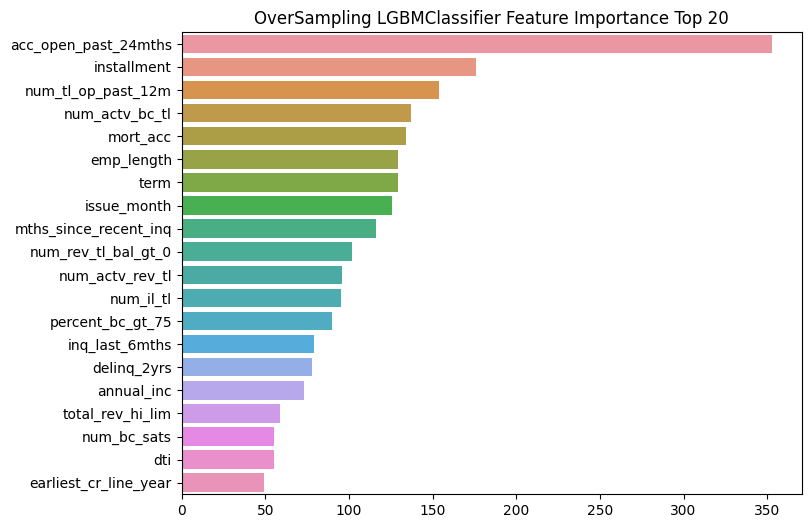

In [12]:
# OverSampling LGBMClassifier
over_lgmc = lightgbm.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=49, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0)
over_lgmc.fit(X_ads, y_ads)
print('LGBMClassifier / OverSampling')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), over_lgmc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), over_lgmc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), over_lgmc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), over_lgmc.predict(X_val)))

# OverSampling LGBMClassifier feature importance
over_lgmc_ft_importance_values = over_lgmc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
over_lgmc_ft_series = pd.Series(over_lgmc_ft_importance_values, index = X_train.columns)
over_lgmc_ft_top20 = over_lgmc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('OverSampling LGBMClassifier Feature Importance Top 20')
sns.barplot(x=over_lgmc_ft_top20, y=over_lgmc_ft_top20.index)
plt.show()

XGBClassifier / OverSampling


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:40:55] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


F1 Score: 0.49737709894407206
Precision Score: 0.5337336630166019
Recall Score: 0.05050640104288531
Confusion Matrix
[[137537   1320]
 [ 28406   1511]]


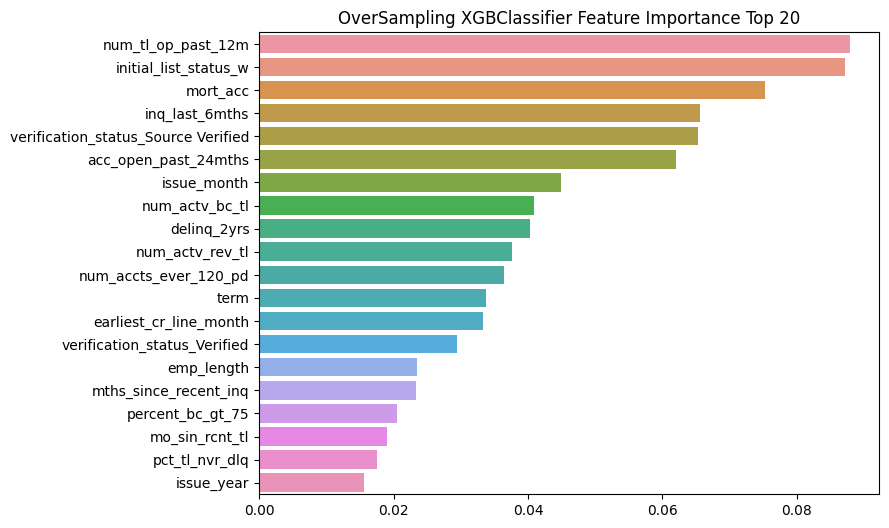

In [13]:
# OverSampling XGBClassifier
over_xgbc = XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device='gpu', early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=-1,
               num_parallel_tree=None, objective='binary:logistic')
over_xgbc.fit(X_ads, y_ads)
print('XGBClassifier / OverSampling')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), over_xgbc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), over_xgbc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), over_xgbc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), over_xgbc.predict(X_val)))

# OverSampling XGBClassifier feature importance
over_xgbc_ft_importance_values = over_xgbc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
over_xgbc_ft_series = pd.Series(over_xgbc_ft_importance_values, index = X_train.columns)
over_xgbc_ft_top20 = over_xgbc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('OverSampling XGBClassifier Feature Importance Top 20')
sns.barplot(x=over_xgbc_ft_top20, y=over_xgbc_ft_top20.index)
plt.show()

# **5. UnderSampling 후 모델 학습**

UnderSampling도 마찬가지로 여러가지 기법이 있지만, TomekLink 도입하기로 했음. CondensedNearestNeighbour도 시행했으나 지나치게 오래 걸려서 적용하기 힘들었습니다.

UnderSampling도 Train Data 한해서만 진행했습니다. 또한, 모델간의 비교를 위해 X_val, y_val인 Validation Data로 그대로 측정했습니다.

In [9]:
undersample = TomekLinks()
#X_train, X_val, y_train, y_val에서 X_train, y_train으로 UnderSampling
X_under, y_under = undersample.fit_resample(X_train, y_train)
print(len(y_under[y_under['loan_status'] == 0]),len(y_under[y_under['loan_status'] == 1]))

529857 119667


UnderSampling 데이터인 상태 / Pycaret을 이용한 최적의 Classification 모델 생성

DecisionTreeClassifier / UnderSampling
F1 Score: 0.5410836961826325
Precision Score: 0.23870760327921556
Recall Score: 0.29782397967710666
Confusion Matrix
[[110441  28416]
 [ 21007   8910]]


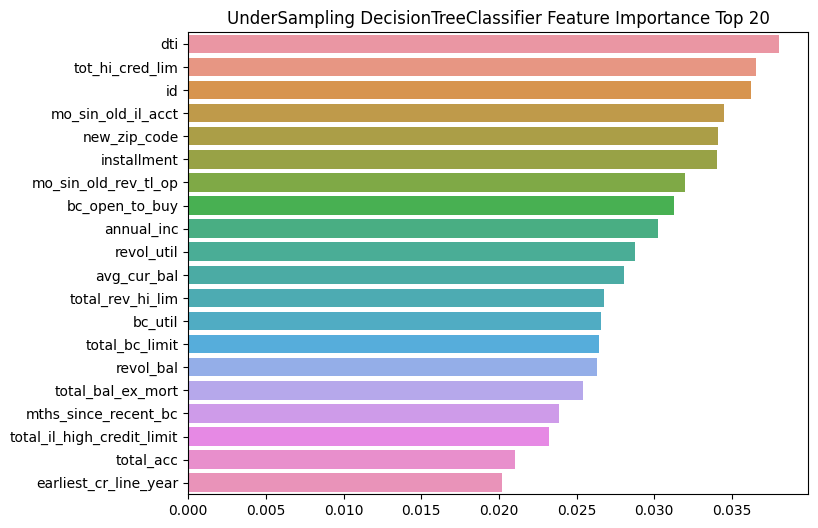

In [16]:
# UnderSampling DecisionTreeClassifier
under_dtc = DecisionTreeClassifier(ccp_alpha=0.0, class_weight = {0: 31, 1: 7}, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        random_state=123, splitter='best')

under_dtc.fit(X_under, y_under)
print('DecisionTreeClassifier / UnderSampling')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), under_dtc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), under_dtc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), under_dtc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), under_dtc.predict(X_val)))

# UnderSampling DecisionTreeClassifier feature importance
under_dtc_ft_importance_values = under_dtc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
under_dtc_ft_series = pd.Series(under_dtc_ft_importance_values, index = X_train.columns)
under_dtc_ft_top20 = under_dtc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('UnderSampling DecisionTreeClassifier Feature Importance Top 20')
sns.barplot(x=under_dtc_ft_top20, y=under_dtc_ft_top20.index)
plt.show()

<ipython-input-10-b4a40aec5059>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  under_etc.fit(X_under, y_under)


ExtraTreesClassifier / UnderSampling
F1 Score: 0.47791449570766414
Precision Score: 0.5118253486961795
Recall Score: 0.02821138483136678
Confusion Matrix
[[138052    805]
 [ 29073    844]]


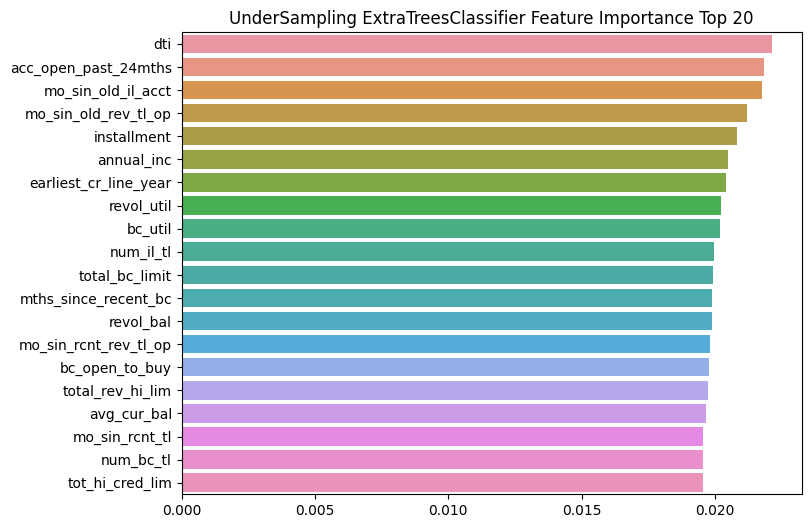

In [10]:
# UnderSampling ExtraTreesClassifier
under_etc = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight = {0: 31, 1: 7},
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

under_etc.fit(X_under, y_under)
print('ExtraTreesClassifier / UnderSampling')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), under_etc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), under_etc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), under_etc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), under_etc.predict(X_val)))

# UnderSampling ExtraTreesClassifier feature importance
under_etc_ft_importance_values = under_etc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
under_etc_ft_series = pd.Series(under_etc_ft_importance_values, index = X_train.columns)
under_etc_ft_top20 = under_etc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('UnderSampling ExtraTreesClassifier Feature Importance Top 20')
sns.barplot(x=under_etc_ft_top20, y=under_etc_ft_top20.index)
plt.show()

<ipython-input-11-1de47767ca80>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  under_rfc.fit(X_under, y_under)


RandomForestClassifier / UnderSampling
F1 Score: 0.5004819542956236
Precision Score: 0.4439227960354721
Recall Score: 0.05689073102249557
Confusion Matrix
[[136725   2132]
 [ 28215   1702]]


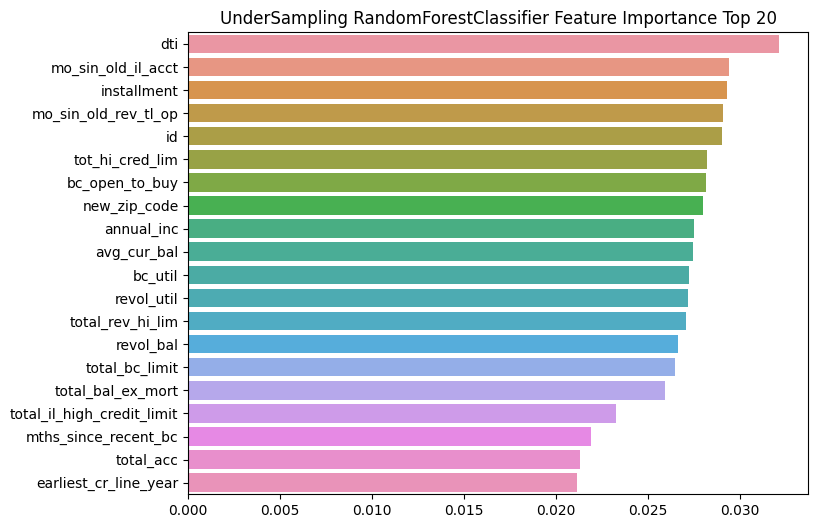

In [11]:
# UnderSampling RandomForestClassifier
under_rfc = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight = {0: 31, 1: 7},
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=-1, oob_score=False,
                        random_state=123, verbose=0, warm_start=False)
under_rfc.fit(X_under, y_under)
print('RandomForestClassifier / UnderSampling')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), under_rfc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), under_rfc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), under_rfc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), under_rfc.predict(X_val)))

# UnderSampling RandomForestClassifier feature importance
under_rfc_ft_importance_values = under_rfc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
under_rfc_ft_series = pd.Series(under_rfc_ft_importance_values, index = X_train.columns)
under_rfc_ft_top20 = under_rfc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('UnderSampling RandomForestClassifier Feature Importance Top 20')
sns.barplot(x=under_rfc_ft_top20, y=under_rfc_ft_top20.index)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 119667, number of negative: 529857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.220276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6984
[LightGBM] [Info] Number of data points in the train set: 649524, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048523 -> initscore=-2.975971
[LightGBM] [Info] Start training from score -2.975971
LGBMClassifier / UnderSampling
F1 Score: 0.45141007846655296
Precision Score: 1.0
Recall Score: 3.342581141157201e-05
Confusion Matrix
[[138857      0]
 [ 29916      1]]


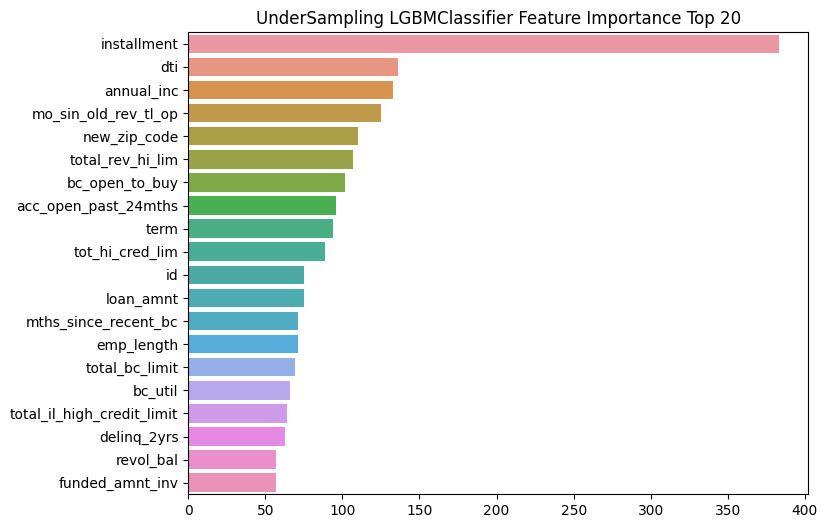

In [12]:
# UnderSampling LGBMClassifier
under_lgmc = lightgbm.LGBMClassifier(boosting_type='gbdt', class_weight = {0: 31, 1: 7}, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0)
under_lgmc.fit(X_under, y_under)
print('LGBMClassifier / UnderSampling')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), under_lgmc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), under_lgmc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), under_lgmc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), under_lgmc.predict(X_val)))

# UnderSampling LGBMClassifier feature importance
under_lgmc_ft_importance_values = under_lgmc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
under_lgmc_ft_series = pd.Series(under_lgmc_ft_importance_values, index = X_train.columns)
under_lgmc_ft_top20 = under_lgmc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('UnderSampling LGBMClassifier Feature Importance Top 20')
sns.barplot(x=under_lgmc_ft_top20, y=under_lgmc_ft_top20.index)
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:03:43] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:03:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier / UnderSampling
F1 Score: 0.5180225558817435
Precision Score: 0.5096788385393752
Recall Score: 0.07744760504061236
Confusion Matrix
[[136628   2229]
 [ 27600   2317]]


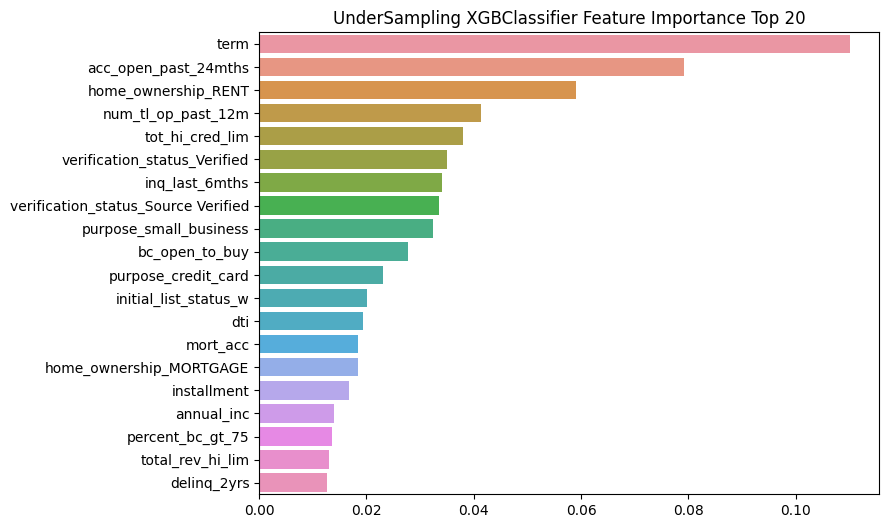

In [13]:
# UnderSampling XGBClassifier
under_xgbc = XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device='gpu', early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=-1,
               num_parallel_tree=None, objective='binary:logistic', class_weight = {0: 31, 1: 7})
under_xgbc.fit(X_under, y_under)
print('XGBClassifier / UnderSampling')
print('F1 Score:',f1_score(y_val['loan_status'].tolist(), under_xgbc.predict(X_val), average='macro'))
print('Precision Score:',precision_score(y_val['loan_status'].tolist(), under_xgbc.predict(X_val)))
print('Recall Score:',recall_score(y_val['loan_status'].tolist(), under_xgbc.predict(X_val)))
print('Confusion Matrix')
print(confusion_matrix(y_val['loan_status'].tolist(), under_xgbc.predict(X_val)))

# UnderSampling XGBClassifier feature importance
under_xgbc_ft_importance_values = under_xgbc.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
under_xgbc_ft_series = pd.Series(under_xgbc_ft_importance_values, index = X_train.columns)
under_xgbc_ft_top20 = under_xgbc_ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('UnderSampling XGBClassifier Feature Importance Top 20')
sns.barplot(x=under_xgbc_ft_top20, y=under_xgbc_ft_top20.index)
plt.show()

# **6. 결과 및 결론**

F1-Score은 전체적으로 비슷했지만 Precision, Recall 등 다양한 요소를 분석했을 때 UnderSampling을 하고 DecisionTree으로 모델링한 쪽이 더 예측력이 높았습니다.

Feature Importance를 통해 확인 결과 dti, tot_hi_cred_lim 등 순으로 영향력이 있었습니다.

In [14]:
result = dict()
result['model'] = ['DecisionTreeClassifier','ExtraTreesClassifier','DecisionTreeClassifier','DecisionTreeClassifier','XGBClassifier','XGBClassifier','RandomForestClassifier','XGBClassifier','RandomForestClassifier','RandomForestClassifier','ExtraTreesClassifier','LGBMClassifier','ExtraTreesClassifier','LGBMClassifier','LGBMClassifier']
result['data'] = ['UnderSampling','OverSampling','Original Data','OverSampling','UnderSampling','Original Data','UnderSampling','OverSampling','Original Data','OverSampling','UnderSampling','OverSampling','Original Data','Original Data','UnderSampling']
result['f1_score'] = [0.5411,0.5393,0.5387,0.5328,0.5180,0.5031,0.5005,0.4974,0.4934,0.4886,0.4779,0.4730,0.4690,0.4515,0.4514]
result['precision_score'] = [0.2387,0.3812,0.2358,0.2276,0.5097,0.5426,0.4439,0.5337,0.4639,0.4465,0.5118,0.5609,0.5126,0.5714,1]
result['recall_score'] = [0.2978,0.1236,0.2848,0.2639,0.0774,0.0572,0.0569,0.0505,0.0472,0.0417,0.0282,0.0225,0.0184,0.0001,'3.3426 * 10^(-5)']

result = pd.DataFrame(result)
result

,model,data,f1_score,precision_score,recall_score
0,DecisionTreeClassifier,UnderSampling,0.5411,0.2387,0.2978
1,ExtraTreesClassifier,OverSampling,0.5393,0.3812,0.1236
2,DecisionTreeClassifier,Original Data,0.5387,0.2358,0.2848
3,DecisionTreeClassifier,OverSampling,0.5328,0.2276,0.2639
4,XGBClassifier,UnderSampling,0.5180,0.5097,0.0774
5,XGBClassifier,Original Data,0.5031,0.5426,0.0572
6,RandomForestClassifier,UnderSampling,0.5005,0.4439,0.0569
7,XGBClassifier,OverSampling,0.4974,0.5337,0.0505
8,RandomForestClassifier,Original Data,0.4934,0.4639,0.0472
9,RandomForestClassifier,OverSampling,0.4886,0.4465,0.0417


In [18]:
# 최종결과물 저장
final_predict = under_dtc.predict(pd.concat([X_train, X_val], axis=0).sort_index())
final_result = pd.DataFrame(final_predict)
final_result.columns = ['predict']
final_result = pd.concat([final_result, df_revised[['loan_status']]], axis=1)
final_result.to_csv('/content/drive/MyDrive/submission.csv')